In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import calendar

In [38]:
df = pd.read_csv('data/raw/train.csv')
store = pd.read_csv('data/raw/store.csv')
df.head()

┌───────────────────────────────── ⚠️ Warning ─────────────────────────────────┐
│ DtypeWarning in                                                             │
│ C:\Users\Admin\AppData\Local\Temp\ipykernel_4856\4126542244.py:1            │
│ Columns (7) have mixed types. Specify dtype option on import or set         │
│ low_memory=False.                                                           │
└─────────────────────────────────────────────────────────────────────────────┘


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Id
0,1,5,2015-07-17,4852,519,1,1,0,0,303445
1,2,5,2015-07-17,4518,495,1,1,0,1,959585
2,3,5,2015-07-17,6679,673,1,1,0,1,739744
3,4,5,2015-07-17,10514,1343,1,1,0,1,864001
4,5,5,2015-07-17,4355,513,1,1,0,1,981931


In [39]:
# Kiểm tra các giá trị ngoại lai theo 2 phương pháp: z-score và IQR
from scipy import stats
z_scores = stats.zscore(df['Sales'])
abs_z_scores = abs(z_scores)
outliers_z = (abs_z_scores > 3)
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = (df['Sales'] < (Q1 - 1.5 * IQR)) | (df['Sales'] > (Q3 + 1.5 * IQR))
print(f"Number of outliers detected by Z-score method: {outliers_z.sum()}")
print(f"Number of outliers detected by IQR method: {outliers_iqr.sum()}")

Number of outliers detected by Z-score method: 9591
Number of outliers detected by IQR method: 26315


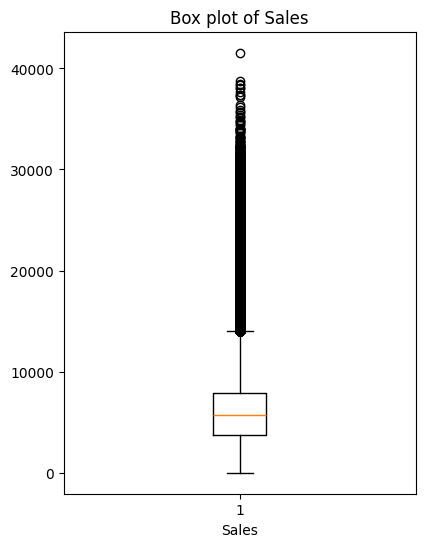

In [40]:
# Vẽ biểu đồ hộp (box plot) để trực quan hóa các giá trị ngoại lai theo cả 2 phương pháp
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.boxplot(df['Sales'], vert=True)
plt.title("Box plot of Sales")
plt.xlabel("Sales")
plt.show()

In [41]:
# Làm giàu dữ liệu để tái sử dụng cho các biểu đồ tiếp theo
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['MonthNum'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.day_name()
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
weekday_order = list(calendar.day_name)
state_holiday_map = {'0': 'No State Holiday', 'a': 'Public Holiday', 'b': 'Easter Holiday', 'c': 'Christmas Holiday'}
school_holiday_map = {0: 'No School Holiday', 1: 'School Holiday'}
promo_map = {0: 'No Promo', 1: 'Promo'}
df['StateHolidayLabel'] = df['StateHoliday'].map(state_holiday_map).fillna('Other State Holiday')
df['SchoolHolidayLabel'] = df['SchoolHoliday'].map(school_holiday_map)
df['PromoLabel'] = df['Promo'].map(promo_map)
df_enriched = df.merge(store[['Store', 'StoreType', 'Assortment']], on='Store', how='left')
df_enriched['StateHolidayBinary'] = (df_enriched['StateHoliday'] != '0').astype(int)
df_enriched['SchoolHolidayBinary'] = df_enriched['SchoolHoliday'].astype(int)
df_enriched['PromoBinary'] = df_enriched['Promo'].astype(int)

[15:12:23] INFO     Using categorical units to plot a list of   category.py:224
                    strings that are all parsable as floats or                 
                    dates. If these strings should be plotted                  
                    as numbers, cast to the appropriate data                   
                    type before plotting.                                      
           INFO     Using categorical units to plot a list of   category.py:224
                    strings that are all parsable as floats or                 
                    dates. If these strings should be plotted                  
                    as numbers, cast to the appropriate data                   
                    type before plotting.                                      
           INFO     Using categorical units to plot a list of   category.py:224
                    strings that are all parsable as floats or                 
                    dates. If these stri

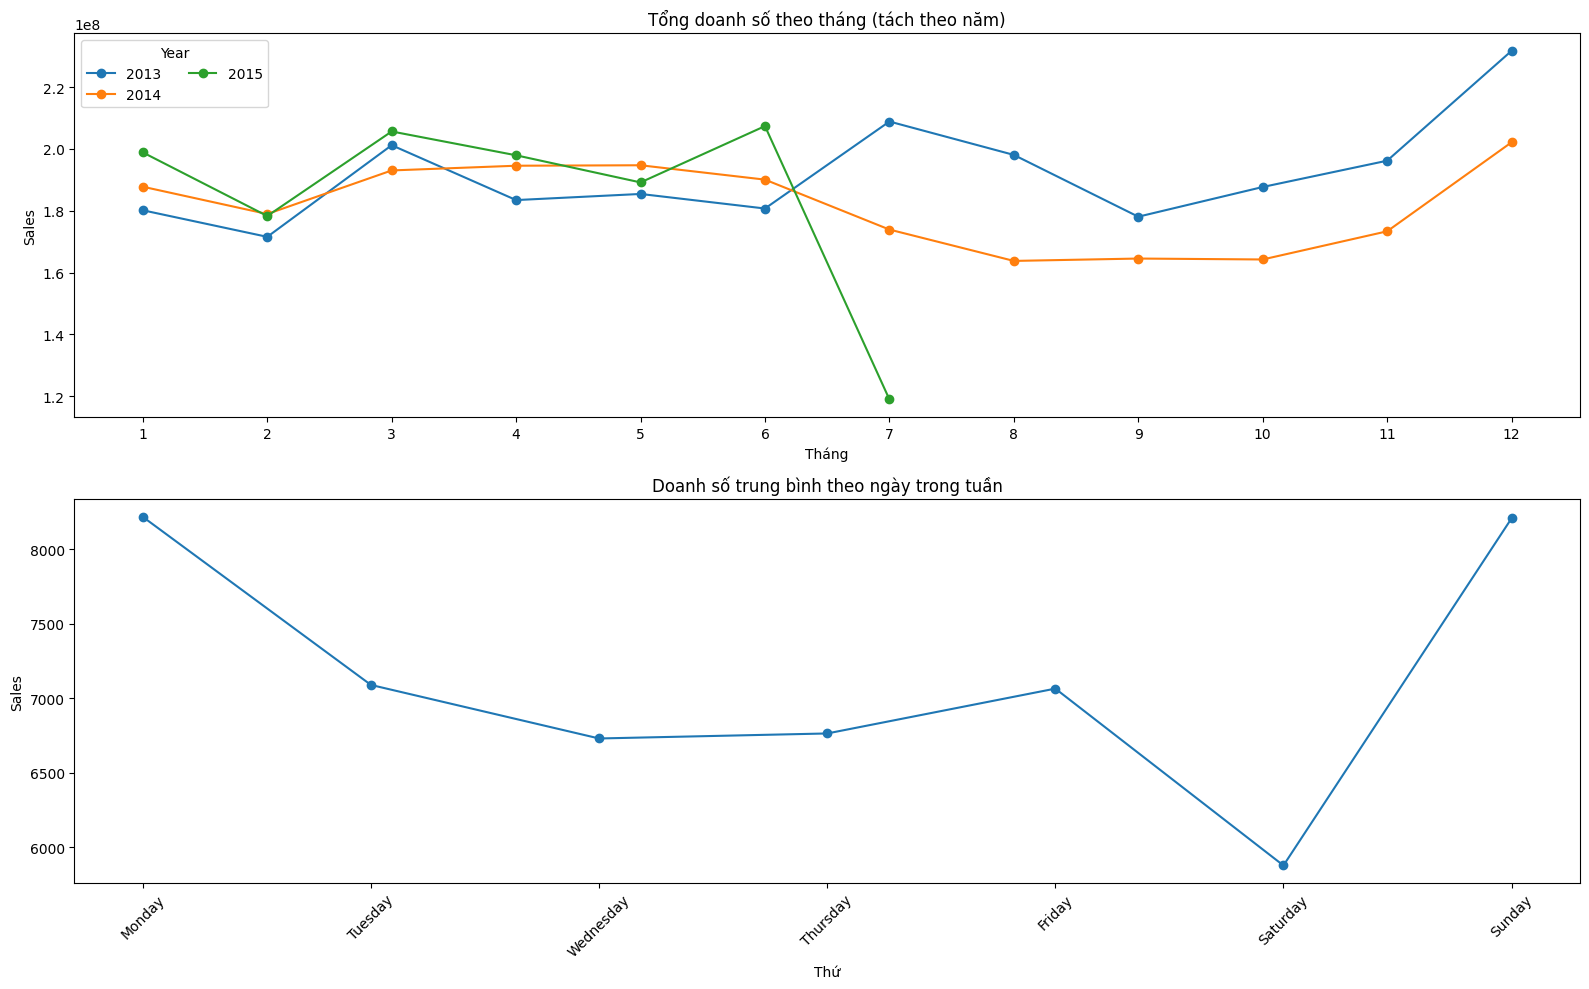

In [51]:
# Xu hướng doanh số theo năm, tháng (từng năm) và ngày trong tuần
# Loại bỏ các điểm dữ liệu có giá trị Sales = 0
df_non_zero = df[df['Sales'] > 0]

yearly_sales = df_non_zero.groupby('Year')['Sales'].sum()
monthly_sales = df_non_zero.groupby(['Year', 'MonthNum'])['Sales'].sum().reset_index().sort_values(['Year', 'MonthNum'])
weekday_sales = df_non_zero.groupby('Weekday')['Sales'].mean().reindex(weekday_order)

fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=False)

for year, subset in monthly_sales.groupby('Year'):
    axes[0].plot(subset['MonthNum'], subset['Sales'], marker='o', label=str(year))
axes[0].set_xticks(range(1, 13))
axes[0].set_title('Tổng doanh số theo tháng (tách theo năm)')
axes[0].set_xlabel('Tháng')
axes[0].set_ylabel('Sales')
axes[0].legend(title='Year', ncol=2)

axes[1].plot(weekday_sales.index, weekday_sales.values, marker='o')
axes[1].set_title('Doanh số trung bình theo ngày trong tuần')
axes[1].set_xlabel('Thứ')
axes[1].set_ylabel('Sales')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

┌───────────────────────────────── ⚠️ Warning ─────────────────────────────────┐
│ FutureWarning in                                                            │
│ C:\Users\Admin\AppData\Local\Temp\ipykernel_4856\848028794.py:8             │
│                                                                             │
│                                                                             │
│ Passing `palette` without assigning `hue` is deprecated and will be removed │
│ in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the │
│ same effect.                                                                │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘


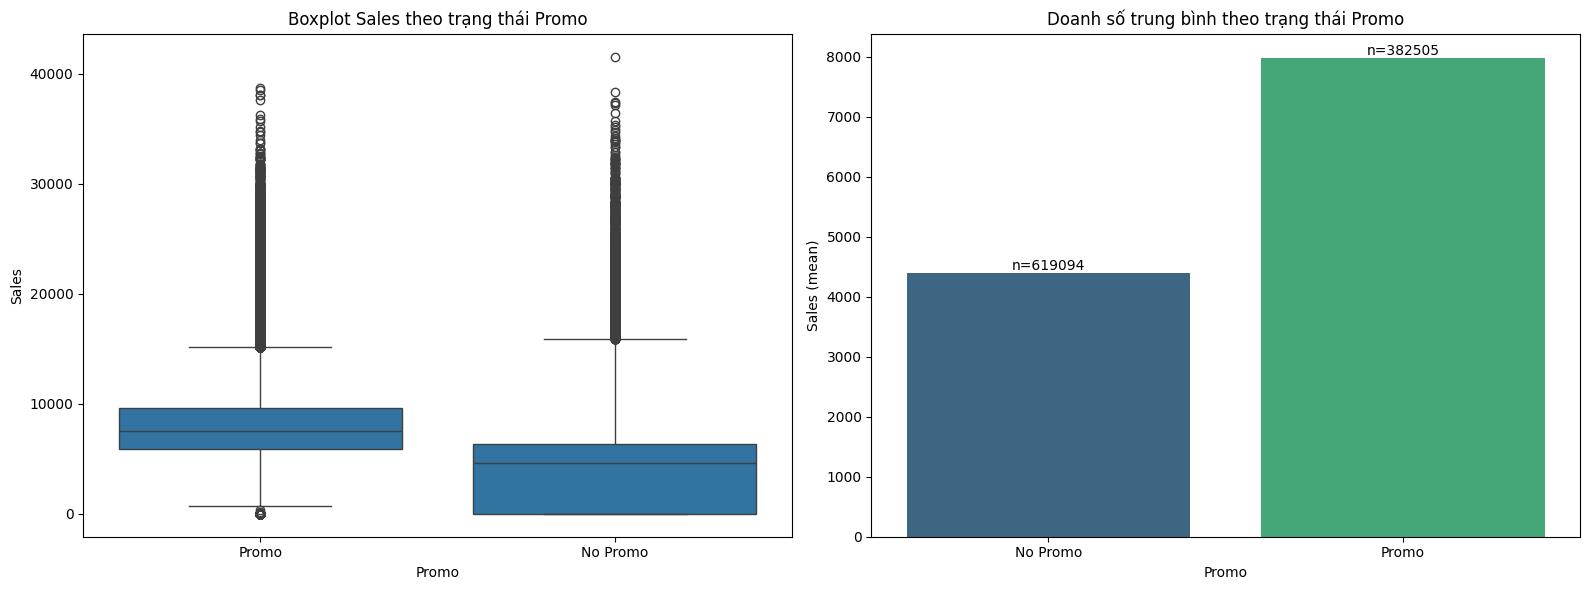

In [43]:
# So sánh doanh số ngày có Promo vs không có Promo
promo_summary = df.groupby('PromoLabel')['Sales'].agg(['mean', 'median', 'count']).reset_index()
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(data=df, x='PromoLabel', y='Sales', ax=axes[0])
axes[0].set_title('Boxplot Sales theo trạng thái Promo')
axes[0].set_xlabel('Promo')
axes[0].set_ylabel('Sales')
sns.barplot(data=promo_summary, x='PromoLabel', y='mean', ax=axes[1], palette='viridis')
for idx, row in promo_summary.iterrows():
    axes[1].text(idx, row['mean'], f"n={int(row['count'])}", ha='center', va='bottom')
axes[1].set_title('Doanh số trung bình theo trạng thái Promo')
axes[1].set_xlabel('Promo')
axes[1].set_ylabel('Sales (mean)')
plt.tight_layout()
plt.show()

┌───────────────────────────────── ⚠️ Warning ─────────────────────────────────┐
│ FutureWarning in                                                            │
│ C:\Users\Admin\AppData\Local\Temp\ipykernel_4856\1172909320.py:6            │
│                                                                             │
│                                                                             │
│ Passing `palette` without assigning `hue` is deprecated and will be removed │
│ in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the │
│ same effect.                                                                │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘


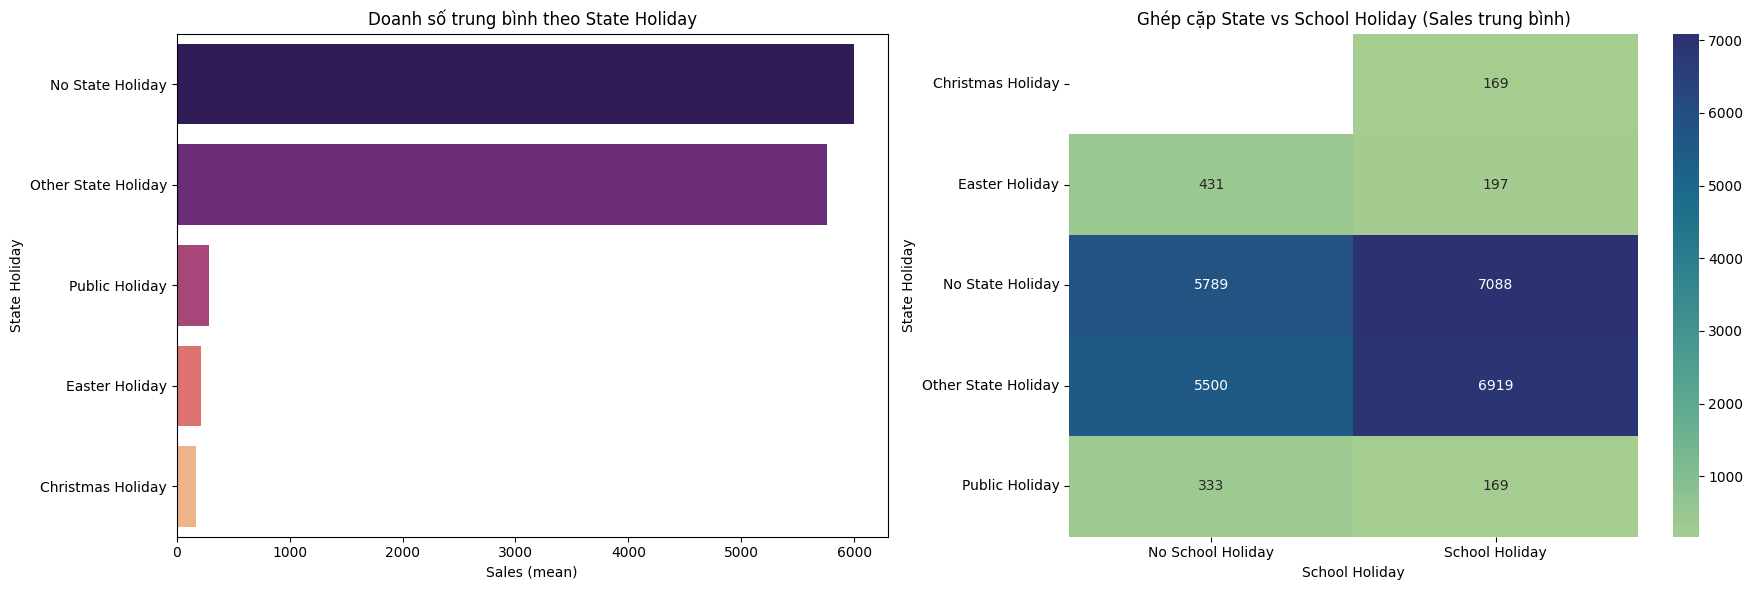

In [44]:
# Tác động của các kỳ nghỉ (State Holiday vs School Holiday)
state_summary = df.groupby('StateHolidayLabel')['Sales'].mean().reset_index().sort_values('Sales', ascending=False)
school_summary = df.groupby('SchoolHolidayLabel')['Sales'].mean().reset_index().sort_values('Sales', ascending=False)
holiday_combo = df.groupby(['StateHolidayLabel', 'SchoolHolidayLabel'])['Sales'].mean().reset_index()
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.barplot(data=state_summary, y='StateHolidayLabel', x='Sales', ax=axes[0], palette='magma')
axes[0].set_title('Doanh số trung bình theo State Holiday')
axes[0].set_xlabel('Sales (mean)')
axes[0].set_ylabel('State Holiday')
sns.heatmap(holiday_combo.pivot(index='StateHolidayLabel', columns='SchoolHolidayLabel', values='Sales'), annot=True, fmt='.0f', cmap='crest', ax=axes[1])
axes[1].set_title('Ghép cặp State vs School Holiday (Sales trung bình)')
axes[1].set_xlabel('School Holiday')
axes[1].set_ylabel('State Holiday')
plt.tight_layout()
plt.show()

┌───────────────────────────────── ⚠️ Warning ─────────────────────────────────┐
│ FutureWarning in                                                            │
│ C:\Users\Admin\AppData\Local\Temp\ipykernel_4856\1433959086.py:7            │
│                                                                             │
│                                                                             │
│ Passing `palette` without assigning `hue` is deprecated and will be removed │
│ in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the │
│ same effect.                                                                │
│                                                                             │
└─────────────────────────────────────────────────────────────────────────────┘
┌───────────────────────────────── ⚠️ Warning ─────────────────────────────────┐
│ FutureWarning in                                                            │
│ C:\Users\Admin\AppData\Local\Temp\ip

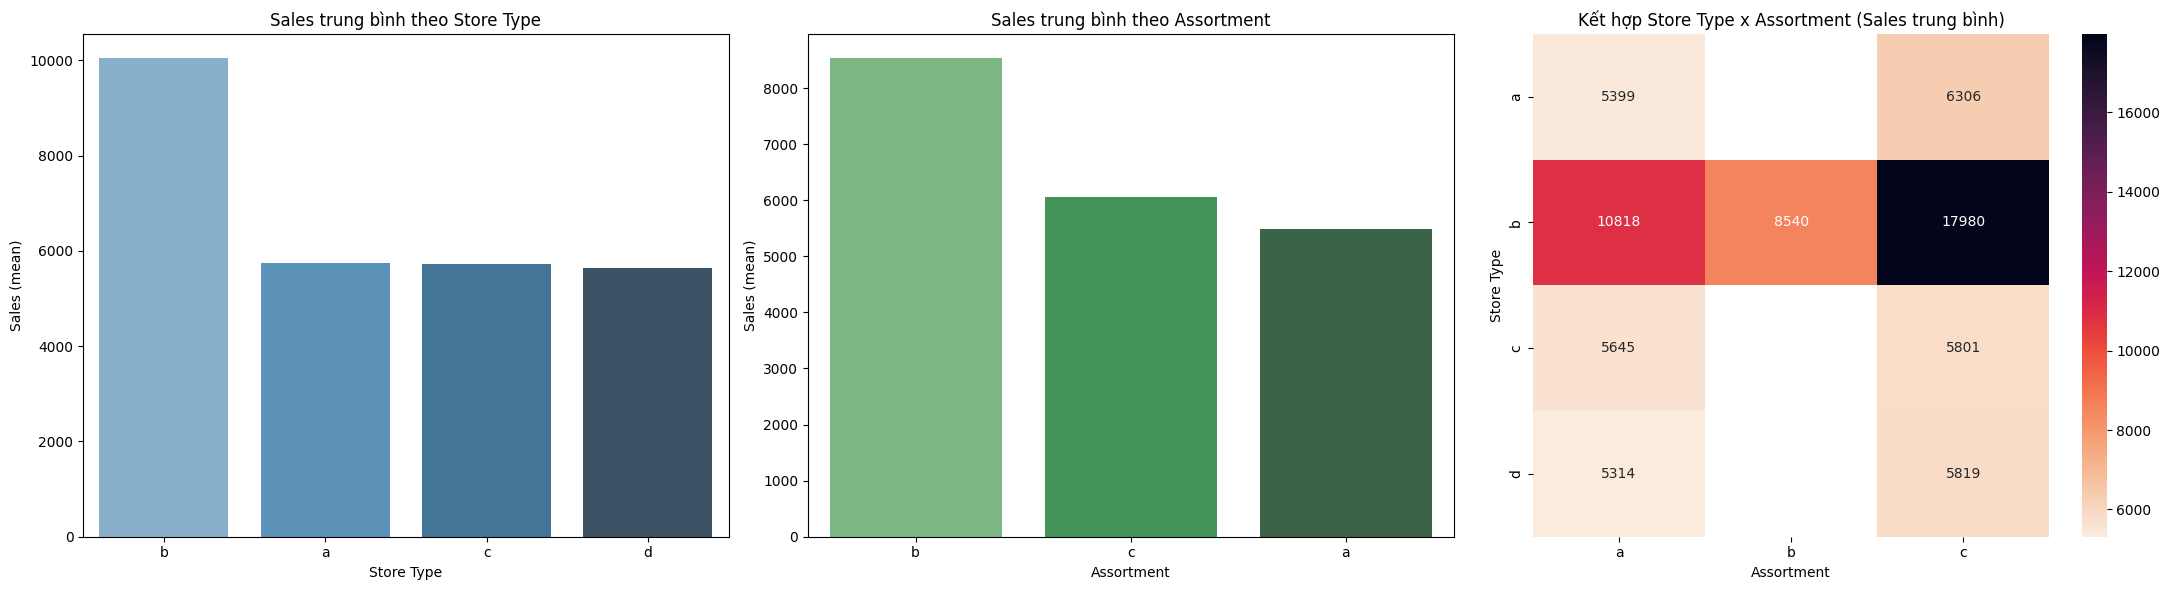

In [45]:
# Doanh số theo loại cửa hàng và mức độ Assortment
type_summary = df_enriched.groupby('StoreType')['Sales'].mean().reset_index().sort_values('Sales', ascending=False)
assort_summary = df_enriched.groupby('Assortment')['Sales'].mean().reset_index().sort_values('Sales', ascending=False)
type_assort = df_enriched.groupby(['StoreType', 'Assortment'])['Sales'].mean().reset_index()
type_assort_pivot = type_assort.pivot(index='StoreType', columns='Assortment', values='Sales')
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
sns.barplot(data=type_summary, x='StoreType', y='Sales', ax=axes[0], palette='Blues_d')
axes[0].set_title('Sales trung bình theo Store Type')
axes[0].set_xlabel('Store Type')
axes[0].set_ylabel('Sales (mean)')
sns.barplot(data=assort_summary, x='Assortment', y='Sales', ax=axes[1], palette='Greens_d')
axes[1].set_title('Sales trung bình theo Assortment')
axes[1].set_xlabel('Assortment')
axes[1].set_ylabel('Sales (mean)')
sns.heatmap(type_assort_pivot, annot=True, fmt='.0f', cmap='rocket_r', ax=axes[2])
axes[2].set_title('Kết hợp Store Type x Assortment (Sales trung bình)')
axes[2].set_xlabel('Assortment')
axes[2].set_ylabel('Store Type')
plt.tight_layout()
plt.show()

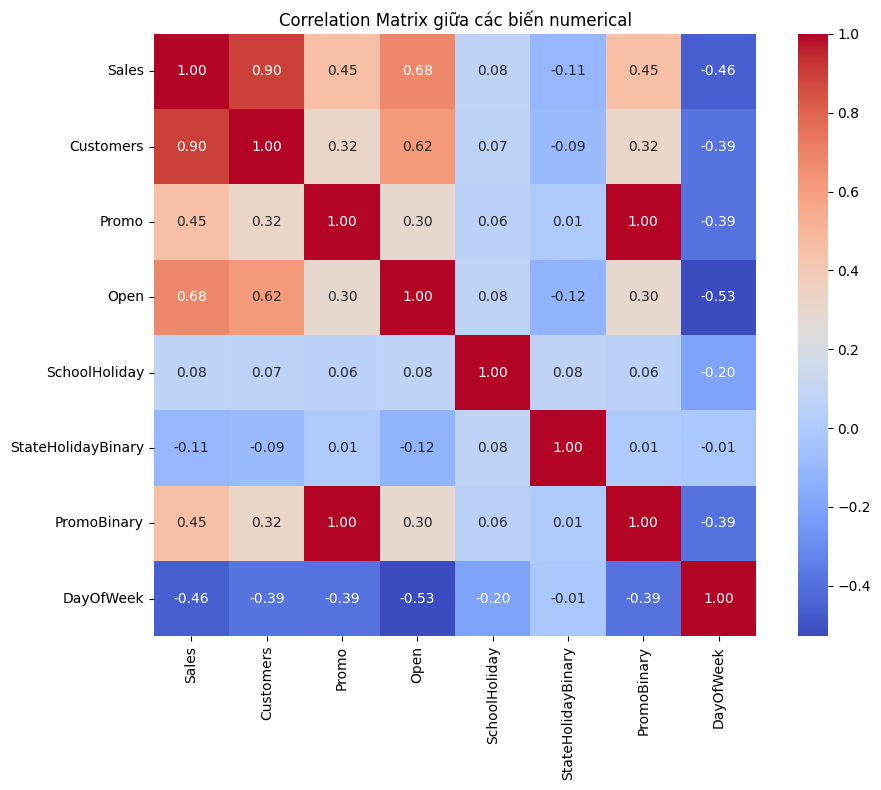

In [46]:
# Ma trận tương quan giữa các biến quan trọng
candidate_features = ['Sales', 'Customers', 'Promo', 'Promo2', 'Open', 'SchoolHoliday', 'StateHolidayBinary', 'PromoBinary', 'DayOfWeek']
available_features = [col for col in candidate_features if col in df_enriched.columns]
corr_matrix = df_enriched[available_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix giữa các biến numerical')
plt.tight_layout()
plt.show()

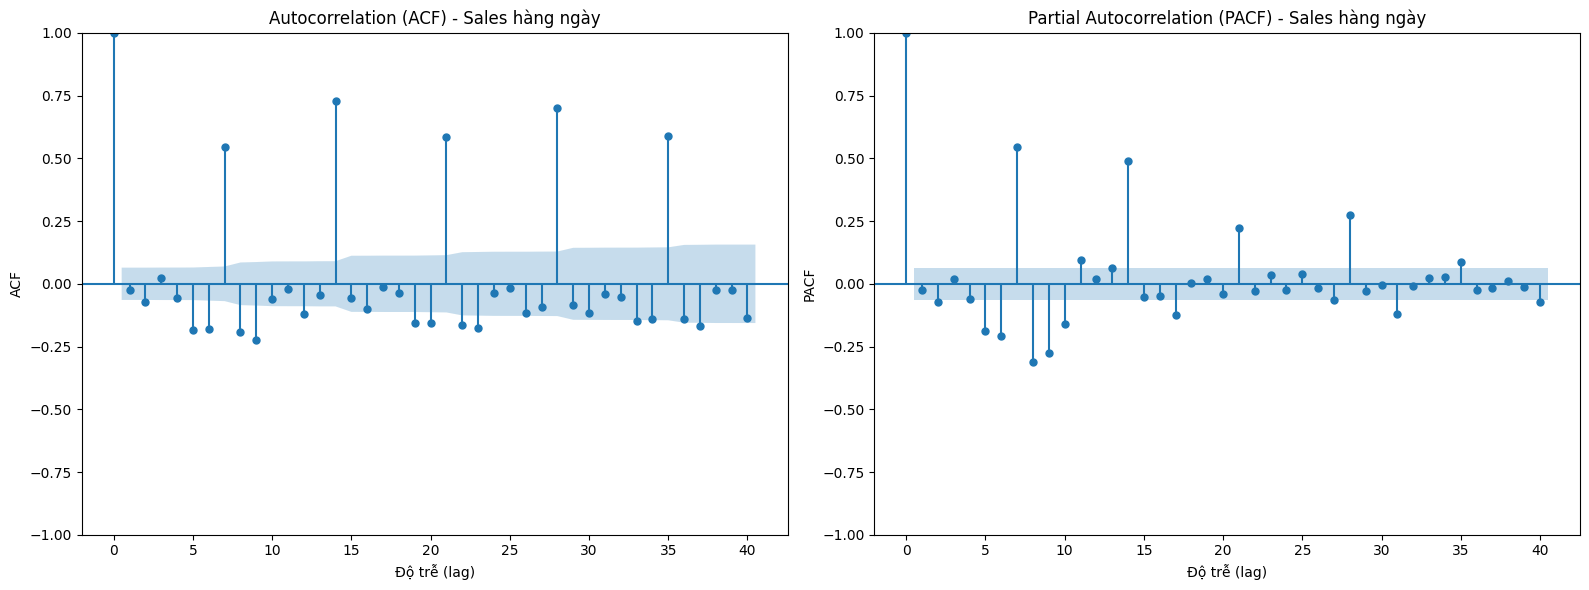

In [47]:
# Phân tích độ trễ và tự tương quan (ACF/PACF)
daily_sales = df.set_index('Date')['Sales'].resample('D').sum().fillna(0)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(daily_sales, ax=axes[0], lags=40)
axes[0].set_title('Autocorrelation (ACF) - Sales hàng ngày')
axes[0].set_xlabel('Độ trễ (lag)')
axes[0].set_ylabel('ACF')
plot_pacf(daily_sales, ax=axes[1], lags=40, method='ywm')
axes[1].set_title('Partial Autocorrelation (PACF) - Sales hàng ngày')
axes[1].set_xlabel('Độ trễ (lag)')
axes[1].set_ylabel('PACF')
plt.tight_layout()
plt.show()